# Water vs WbLS (crossing muon)

In [1]:
import numpy as np
import uproot
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from datetime import timedelta, datetime

import re
import os
import sys
from scipy.optimize import curve_fit

from analysis_helper import *

In [2]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 12,
         'axes.labelsize': 14,
         'axes.titlesize':14,}
pylab.rcParams.update(params)
plt.rcParams["font.family"] = "Times New Roman"

In [3]:
def gauss(x, mu, sigma, N):
    """
    A gaussian function
    """
    arg = (x-mu)/sigma
    Norm=N*1/np.sqrt(2*np.pi)/sigma
    return Norm* np.exp(-0.5*arg*arg)

def calc_chi2(func, xdata, ydata, popt):
    """
    Pearson chi2
    """
    y = func(xdata, *popt)
    r = (y-ydata)/np.sqrt(ydata)
    r2 = np.square(r)
    return np.sum(r2)

def fit_gauss(h, fit_range, p0=[1, 1, 1]):
    """
    A function that fits binned data. It fits data twice.
    If covariance from the first fit is bad, do the second fit with smaller range
    
    Args:
        h: return of plt.hist
        fit_range: list of two float (ex. [1.0, 2.0] means fit range is from 1.0 to 2.0
    """
    ydata = h[0]
    xdata = (h[1][1:]+h[1][:-1])/2
    tot = np.trapz(ydata, xdata)
    p0[2]=tot
    bw = xdata[1]-xdata[0]
    # 1st fit
    fit_mask = (xdata>fit_range[0]) & (xdata<fit_range[1])
    sigma = np.sqrt(ydata[fit_mask])
    popt, pcov = curve_fit(gauss, xdata[fit_mask], ydata[fit_mask], sigma=sigma, p0=p0)
    x = np.linspace(xdata[fit_mask][0], xdata[fit_mask][-1], 100)    
    y = gauss(x, popt[0], popt[1], 1)
    
    chi2 = calc_chi2(gauss, xdata[fit_mask], ydata[fit_mask], popt)
    dof = len(xdata[fit_mask])-2    
    err = np.diag(pcov)
    err = np.sqrt(err)
    
    return dict(
        x=x, 
        y=y*tot,
        popt=popt,
        chi2=chi2,
        dof=dof,
        err=err,
        nbin=len(xdata[fit_mask]),
    )

In [4]:
def apply_muon_cuts(rq):
    event_mask = (rq['npulse']>0) & (rq['event_sanity']==0)

    ch_std = rq['ch_roi0_std_mV']
    ch_std_mask = ch_std<0.6
    std_mask = np.all(ch_std_mask, axis=1)

    ch_low = rq['ch_roi1_low_pe']
    ch_low_mask = (ch_low>-0.4)
    low_mask = np.all(ch_std_mask, axis=1)

    event_mask = (event_mask) & (std_mask) & (low_mask)

    for k in rq.keys():
        rq[k] = rq[k][event_mask]
        
    n_evts = len(rq['event_id'])
    area_sum = np.zeros(n_evts)
    area_bot = np.zeros(n_evts)
    area_side = np.zeros(n_evts)
    area_row12 = np.zeros(n_evts)
    area_row34 = np.zeros(n_evts)
    area_row1 = np.zeros(n_evts)
    area_row2 = np.zeros(n_evts)
    area_row3 = np.zeros(n_evts)
    area_row4 = np.zeros(n_evts)
    area_col12 = np.zeros(n_evts)
    area_col34 = np.zeros(n_evts)
    area_col1 = np.zeros(n_evts)
    area_col2 = np.zeros(n_evts)
    area_col3 = np.zeros(n_evts)
    area_col4 = np.zeros(n_evts)
    peak_time = np.zeros(n_evts)
    area_sum_crx = []
    area_bot_crx = []
    area_side_crx = []
    area_row12_crx = []
    area_row34_crx = []
    area_col12_crx = []
    area_col34_crx = []
    width_bot_crx = []
    width_side_crx = []
    area_sb_crx = []
    event_id_crx = []
    peak_time_crx = []
    
    for i in range(n_evts):
        area_sum[i] = rq['pulse_area_sum_pe'][i][0]
        area_bot[i] =  rq['pulse_area_bot_pe'][i][0]
        area_side[i] =  rq['pulse_area_side_pe'][i][0]
        area_col1[i] = rq['pulse_area_col1_pe'][i][0]
        area_col2[i] = rq['pulse_area_col2_pe'][i][0]
        area_col3[i] = rq['pulse_area_col3_pe'][i][0]
        area_col4[i] = rq['pulse_area_col4_pe'][i][0]
        area_row1[i] = rq['pulse_area_row1_pe'][i][0]
        area_row2[i] = rq['pulse_area_row2_pe'][i][0]
        area_row3[i] = rq['pulse_area_row3_pe'][i][0]
        area_row4[i] = rq['pulse_area_row4_pe'][i][0]
        area_row12[i] =  area_row1[i] + area_row2[i]
        area_row34[i] =  area_row3[i] + area_row4[i]
        area_col12[i] = area_col1[i] + area_col2[i]
        area_col34[i] = area_col3[i] + area_col4[i]
        peak_time[i] = rq['pulse_ptime_ns'][i][0]
    
        pad_pC = rq['aux_ch_area_mV'][i]/50
        cross_muon = np.any(pad_pC>15)
        if cross_muon:
            area_sum_crx.append( rq['pulse_area_sum_pe'][i][0])
            area_bot_crx.append(rq['pulse_area_bot_pe'][i][0])
            area_side_crx.append(rq['pulse_area_side_pe'][i][0])
            area_row12_crx.append(rq['pulse_area_row1_pe'][i][0]+rq['pulse_area_row2_pe'][i][0])
            area_row34_crx.append(rq['pulse_area_row3_pe'][i][0]+rq['pulse_area_row4_pe'][i][0])
            area_col12_crx.append(rq['pulse_area_col1_pe'][i][0]+rq['pulse_area_col2_pe'][i][0])
            area_col34_crx.append(rq['pulse_area_col3_pe'][i][0]+rq['pulse_area_col4_pe'][i][0])
            area_sb_crx.append(rq['pulse_area_side_pe'][i][0]/rq['pulse_area_bot_pe'][i][0])
            event_id_crx.append(rq['event_id'][i])
            w_side = rq['pulse_aft90_side_ns'][i][0]-rq['pulse_aft10_side_ns'][i][0]
            w_bot = rq['pulse_aft90_bot_ns'][i][0]-rq['pulse_aft10_bot_ns'][i][0]
            width_bot_crx.append(w_bot)
            width_side_crx.append(w_side)
            peak_time_crx.append(rq['pulse_ptime_ns'][i][0])
            
    return dict(
        n_evts=n_evts,
        area_sum=area_sum,
        area_bot=area_bot,
        area_side=area_side,
        area_row1=area_row1,
        area_row2=area_row2,
        area_row3=area_row3,
        area_row4=area_row4,
        area_row12=area_row12,
        area_row34=area_row34,
        area_col1=area_col1,
        area_col2=area_col2,
        area_col3=area_col3,
        area_col4=area_col4,
        area_col12=area_col12,
        area_col34=area_col34,
        peak_time=peak_time,
        area_sum_crx=np.array(area_sum_crx),
        area_bot_crx=np.array(area_bot_crx),
        area_side_crx=np.array(area_side_crx),
        area_row12_crx=np.array(area_row12_crx),
        area_row34_crx=np.array(area_row34_crx),
        area_col12_crx=np.array(area_col12_crx),
        area_col34_crx=np.array(area_col34_crx),
        area_sb_crx=np.array(area_sb_crx),
        event_id_crx = np.array(event_id_crx),
        width_bot_crx=np.array(width_bot_crx),
        width_side_crx=np.array(width_side_crx),
        peak_time_crx=np.array(peak_time_crx)
    )



def apply_crossing_muon_cuts(rq):
    event_mask = (rq['npulse']>0) & (rq['event_sanity']==0)
    ch_std = rq['ch_roi0_std_mV']
    ch_std_mask = ch_std<0.6
    std_mask = np.all(ch_std_mask, axis=1)

    ch_low = rq['ch_roi1_low_pe']
    ch_low_mask = (ch_low>-0.4)
    low_mask = np.all(ch_std_mask, axis=1)
    event_mask = (event_mask) & (std_mask) & (low_mask)
    for k in rq.keys():
        rq[k] = rq[k][event_mask]
    n_evts = len(rq['event_id'])

    area_sum_crx = []
    area_bot_crx = []
    area_side_crx = []
    area_row12_crx = []
    area_row34_crx = []
    area_col12_crx = []
    area_col34_crx = []
    rise_bot_crx = []
    rise_side_crx = []
    fall_bot_crx = []
    fall_side_crx = []
    width_bot_crx = []
    width_side_crx = []
    area_sb_crx = []
    event_id_crx = []
    peak_time_crx = []
    max_frac_crx = []
    area_max_ch_id_crx = []
    area_max_frac_crx = []
    area_side_roi1_crx = []
    area_side_roi2_crx = []
    area_bot_roi1_crx = []
    area_bot_roi2_crx = []
    
    for i in range(n_evts):
        pad_pC = rq['aux_ch_area_mV'][i]/50
        cross_muon = np.any(pad_pC>15)
        if cross_muon:
            area_sum_crx.append( rq['pulse_area_sum_pe'][i][0])
            area_bot_crx.append(rq['pulse_area_bot_pe'][i][0])
            area_side_crx.append(rq['pulse_area_side_pe'][i][0])
            area_row12_crx.append(rq['pulse_area_row1_pe'][i][0]+rq['pulse_area_row2_pe'][i][0])
            area_row34_crx.append(rq['pulse_area_row3_pe'][i][0]+rq['pulse_area_row4_pe'][i][0])
            area_col12_crx.append(rq['pulse_area_col1_pe'][i][0]+rq['pulse_area_col2_pe'][i][0])
            area_col34_crx.append(rq['pulse_area_col3_pe'][i][0]+rq['pulse_area_col4_pe'][i][0])
            area_sb_crx.append(rq['pulse_area_side_pe'][i][0]/rq['pulse_area_bot_pe'][i][0])
            event_id_crx.append(rq['event_id'][i])
            rise_bot_crx.append(rq['pulse_rise_bot_ns'][i][0])
            rise_side_crx.append(rq['pulse_rise_side_ns'][i][0])
            fall_bot_crx.append(rq['pulse_fall_bot_ns'][i][0])
            fall_side_crx.append(rq['pulse_fall_side_ns'][i][0])
            w_bot = rq['pulse_aft90_bot_ns'][i][0]-rq['pulse_aft10_bot_ns'][i][0]
            w_side = rq['pulse_aft90_side_ns'][i][0]-rq['pulse_aft10_side_ns'][i][0]
            width_bot_crx.append(w_bot)
            width_side_crx.append(w_side)
            peak_time_crx.append(rq['pulse_ptime_ns'][i][0])
            area_max_frac_crx.append(rq['pulse_area_max_frac'][i][0])
            area_max_ch_id_crx.append(rq['pulse_area_max_ch_id'][i][0])
            ch_id = rq['ch_id'][i]
            area_bot_roi1_crx.append( np.sum(rq['ch_roi1_area_pe'][i][ch_id<300]) )
            area_bot_roi2_crx.append( np.sum(rq['ch_roi2_area_pe'][i][ch_id<300]) )
            area_side_roi1_crx.append( np.sum(rq['ch_roi1_area_pe'][i][ch_id>=300]) )
            area_side_roi2_crx.append( np.sum(rq['ch_roi2_area_pe'][i][ch_id>=300]) )

            
    return dict(
        area_sum_crx=np.array(area_sum_crx),
        area_bot_crx=np.array(area_bot_crx),
        area_side_crx=np.array(area_side_crx),
        area_row12_crx=np.array(area_row12_crx),
        area_row34_crx=np.array(area_row34_crx),
        area_col12_crx=np.array(area_col12_crx),
        area_col34_crx=np.array(area_col34_crx),
        area_sb_crx=np.array(area_sb_crx),
        event_id_crx = np.array(event_id_crx),
        rise_bot_crx=np.array(rise_bot_crx),
        rise_side_crx=np.array(rise_side_crx),
        fall_bot_crx=np.array(fall_bot_crx),
        fall_side_crx=np.array(fall_side_crx),
        width_bot_crx=np.array(width_bot_crx),
        width_side_crx=np.array(width_side_crx),
        peak_time_crx=np.array(peak_time_crx),
        area_max_frac_crx=np.array(area_max_frac_crx),
        area_max_ch_id_crx=np.array(area_max_ch_id_crx),
        area_bot_roi1_crx = np.array(area_bot_roi1_crx),
        area_bot_roi2_crx = np.array(area_bot_roi2_crx),
        area_side_roi1_crx = np.array(area_side_roi1_crx),
        area_side_roi2_crx = np.array(area_side_roi2_crx),
    )



In [5]:
data_file_0 = [
    "phase0_muon_water_220901T1040_rq.root",
    "phase0_muon_water_220901T2011_rq.root",
    "phase0_muon_water_220907T1540_rq.root",
    "phase0_muon_water_220907T1633_rq.root",
    "phase0_muon_water_220907T2200_rq.root",
    "phase0_muon_water_220908T1000_rq.root",
    "phase0_muon_water_220908T1405_rq.root",
    "phase0_muon_water_220908T1947_rq.root",
    "phase0_muon_water_220909T1007_rq.root",
    "phase0_muon_water_220909T1502_rq.root",
    "phase0_muon_water_220909T2202_rq.root",
    "phase0_muon_water_220910T0013_rq.root",
    "phase0_muon_water_220910T0902_rq.root",
    "phase0_muon_water_220911T0050_rq.root",
    "phase0_muon_water_220911T0922_rq.root",
    "phase0_muon_water_220911T1516_rq.root",
    "phase0_muon_water_220911T2200_rq.root",
    "phase0_muon_water_220912T0654_rq.root",
    "phase0_muon_water_220912T1439_rq.root",
    "phase0_muon_water_220912T1735_rq.root",
    "phase0_muon_water_220913T0036_rq.root",
    "phase0_muon_water_220913T0831_rq.root",
    "phase0_muon_water_220913T1107_rq.root",
    "phase0_muon_water_220913T2307_rq.root",
    "phase0_muon_water_220914T0019_rq.root",
    "phase0_muon_water_220914T0939_rq.root",
    "phase0_muon_water_220914T1802_rq.root",
    "phase0_muon_water_220915T0002_rq.root",
    "phase0_muon_water_220915T0955_rq.root",
    "phase0_muon_water_220915T2110_rq.root",
    "phase0_muon_water_220916T0109_rq.root",
    "phase0_muon_water_220916T0908_rq.root",
    "phase0_muon_water_220916T1826_rq.root",
    "phase0_muon_water_220917T0020_rq.root",
    "phase0_muon_water_220917T0835_rq.root",
    "phase0_muon_water_220917T2131_rq.root",
    "phase0_muon_water_220918T0002_rq.root",
    "phase0_muon_water_220918T0854_rq.root",
    "phase0_muon_water_220918T1459_rq.root",
    "phase0_muon_water_220918T1559_rq.root",
    "phase0_muon_water_220918T2112_rq.root",
    "phase0_muon_water_220918T2328_rq.root",
    "phase0_muon_water_220919T0656_rq.root",
    "phase0_muon_water_220919T1743_rq.root",
    "phase0_muon_water_220920T0054_rq.root",
    "phase0_muon_water_220920T1046_rq.root",
    "phase0_muon_water_220920T1725_rq.root",
]

data_file_1 = [
    "phase1_muon_wbls_1pct_221025T0101_rq.root",
    "phase1_muon_wbls_1pct_221025T0930_rq.root",
    "phase1_muon_wbls_1pct_221025T1640_rq.root",
    "phase1_muon_wbls_1pct_221026T0013_rq.root",
    "phase1_muon_wbls_1pct_221026T1018_rq.root",
    "phase1_muon_wbls_1pct_221026T1756_rq.root",
    "phase1_muon_wbls_1pct_221027T0049_rq.root",
    "phase1_muon_wbls_1pct_221027T1027_rq.root",
    "phase1_muon_wbls_1pct_221027T1742_rq.root",
    "phase1_muon_wbls_1pct_221027T1859_rq.root",
    "phase1_muon_wbls_1pct_221028T1029_rq.root",
    "phase1_muon_wbls_1pct_221028T1717_rq.root",
    "phase1_muon_wbls_1pct_221029T0234_rq.root",
    "phase1_muon_wbls_1pct_221029T0751_rq.root",
    "phase1_muon_wbls_1pct_221029T1603_rq.root",
    "phase1_muon_wbls_1pct_221029T2320_rq.root",
    "phase1_muon_wbls_1pct_221030T0740_rq.root",
    "phase1_muon_wbls_1pct_221030T1840_rq.root",
    "phase1_muon_wbls_1pct_221031T0659_rq.root",
    "phase1_muon_wbls_1pct_221031T1657_rq.root",
    "phase1_muon_wbls_1pct_221031T2257_rq.root",
    "phase1_muon_wbls_1pct_221101T0927_rq.root",
    "phase1_muon_wbls_1pct_221101T1718_rq.root",
    "phase1_muon_wbls_1pct_221102T0036_rq.root",
    "phase1_muon_wbls_1pct_221102T0904_rq.root",
    "phase1_muon_wbls_1pct_221102T1739_rq.root",
    "phase1_muon_wbls_1pct_221102T2341_rq.root",
    "phase1_muon_wbls_1pct_221103T0932_rq.root",
    "phase1_muon_wbls_1pct_221103T1740_rq.root",
    "phase1_muon_wbls_1pct_221103T2324_rq.root",
    "phase1_muon_wbls_1pct_221105T0744_rq.root",
    "phase1_muon_wbls_1pct_221105T1052_rq.root",
    "phase1_muon_wbls_1pct_221105T2202_rq.root",
    "phase1_muon_wbls_1pct_221106T0627_rq.root",
    "phase1_muon_wbls_1pct_221106T1258_rq.root",
    "phase1_muon_wbls_1pct_221107T0030_rq.root",
    "phase1_muon_wbls_1pct_221107T0928_rq.root",
    "phase1_muon_wbls_1pct_221107T1322_rq.root",
    "phase1_muon_wbls_1pct_221107T2308_rq.root",
    "phase1_muon_wbls_1pct_221108T0914_rq.root",
    "phase1_muon_wbls_1pct_221108T1700_rq.root",
    "phase1_muon_wbls_1pct_221108T2329_rq.root",
    "phase1_muon_wbls_1pct_221109T0722_rq.root",
    "phase1_muon_wbls_1pct_221109T1520_rq.root",
    "phase1_muon_wbls_1pct_221109T2159_rq.root",
    "phase1_muon_wbls_1pct_221110T0751_rq.root",
    "phase1_muon_wbls_1pct_221110T1656_rq.root",
    "phase1_muon_wbls_1pct_221110T2300_rq.root",
]

path_0 = make_file_paths('../data/rq/v1.0.4f/', data_file_0)
path_1 = make_file_paths('../data/rq/v1.0.4f/', data_file_1)

f= uproot.open(path_0[0])
var_names = []
for k in f['event'].keys():
    if k=='ch_roi1_low_pe':
        var_names.append(k)
    if k=='ch_roi2_area_pe':
        var_names.append(k)
    if k=='ch_roi1_area_pe':
        var_names.append(k)
    if k=='ch_roi0_std_mV':
        var_names.append(k)
    if k[0:6] == 'ch_roi':
        continue
    var_names.append(k)
rq0 = get_concatenated_data(path_0, var_names=var_names)
rq1 = get_concatenated_data(path_1, var_names=var_names)

In [6]:
f = uproot.open(path_0[-1])
skip_pmt_channels = f['run_info']['cfg_skip_pmt_channels'].array()
print(skip_pmt_channels)

[[102, 104, 308]]


In [7]:
rq0.keys()

dict_keys(['event_id', 'event_ttt', 'event_sanity', 'event_saturated', 'ch_id', 'ch_saturated', 'ch_roi1_area_pe', 'ch_roi2_area_pe', 'ch_roi1_low_pe', 'ch_roi0_std_mV', 'aux_ch_id', 'aux_ch_area_mV', 'npulse', 'pulse_id', 'pulse_start', 'pulse_end', 'pulse_area_sum_pe', 'pulse_area_bot_pe', 'pulse_area_side_pe', 'pulse_area_row1_pe', 'pulse_area_row2_pe', 'pulse_area_row3_pe', 'pulse_area_row4_pe', 'pulse_area_col1_pe', 'pulse_area_col2_pe', 'pulse_area_col3_pe', 'pulse_area_col4_pe', 'pulse_area_user_pe', 'pulse_aft10_sum_ns', 'pulse_aft10_bot_ns', 'pulse_aft10_side_ns', 'pulse_aft10_row1_ns', 'pulse_aft10_row2_ns', 'pulse_aft10_row3_ns', 'pulse_aft10_row4_ns', 'pulse_aft90_sum_ns', 'pulse_aft90_bot_ns', 'pulse_aft90_side_ns', 'pulse_aft90_row1_ns', 'pulse_aft90_row2_ns', 'pulse_aft90_row3_ns', 'pulse_aft90_row4_ns', 'pulse_rise_sum_ns', 'pulse_rise_bot_ns', 'pulse_rise_side_ns', 'pulse_fall_sum_ns', 'pulse_fall_bot_ns', 'pulse_fall_side_ns', 'pulse_fp40_sum', 'pulse_fp40_bot', 'puls

In [8]:
# mu0 = apply_muon_cuts(rq0)
# mu1 = apply_muon_cuts(rq1)
mu0=apply_crossing_muon_cuts(rq0)
mu1=apply_crossing_muon_cuts(rq1)

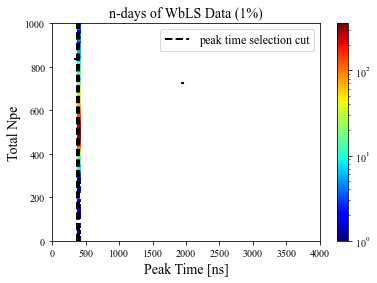

In [62]:
"""
Check peak time cut
"""

plt.figure()
pT_min = 370
pT_max = 405
# h = plt.hist2d(mu1['peak_time_crx'], mu1['area_sum_crx'], bins=[75, 100], range=((320, 460), (0, 1000)), norm=colors.LogNorm(), cmap='jet');
h = plt.hist2d(mu1['peak_time_crx'], mu1['area_sum_crx'], bins=[75, 100], range=((0, 4000), (0, 1000)), norm=colors.LogNorm(), cmap='jet');

plt.vlines([pT_min, pT_max], 0, 1e4, color='k', linestyle='--', linewidth=2, label='peak time selection cut')
plt.colorbar()
plt.xlabel('Peak Time [ns]', fontsize=14)
plt.ylabel('Total Npe', fontsize=14)
plt.title('n-days of WbLS Data (1%)')
plt.ylim([0, 1000])
plt.legend()
plt.show()

In [ ]:
(mu1['peak_time_crx']>=pT_min & mu1['peak_time_crx']<pT_max

0.13068398930072603


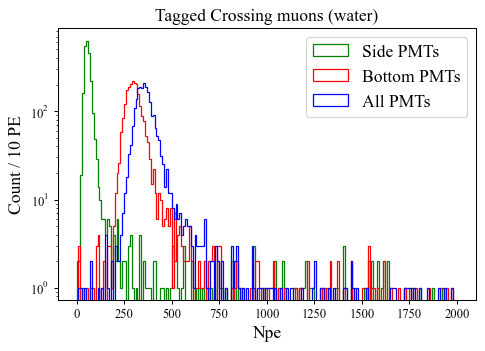

In [13]:
color_list=['blue', 'red', 'green']

do_fit=False
plot_range=[0, 2000]
nbinx=200

plt.figure(dpi=90)
time_mask= (mu0['peak_time_crx']>=pT_min) & (mu0['peak_time_crx']<pT_max)
mask = time_mask
# side_mask = mu0['area_max_ch_id_crx']<=400
# mask = (time_mask) & (side_mask)


big_event_mask = mu0['area_sum_crx']>1000
print(len(mu0['event_id_crx'][big_event_mask])/len(mu0['event_id_crx']))
#print(mu0['event_id_crx'][big_event_mask])

hist={}

# hist['side']=plt.hist(mu0['area_side_crx'][time_mask], bins=nbinx, range=plot_range, 
#          color=color_list[2], histtype='step', label='Side PMTs')
# hist['bot']=plt.hist(mu0['area_bot_crx'][time_mask], bins=nbinx, range=plot_range,  
#          color=color_list[1],  histtype='step', label='Bottom PMTs')
# hist['sum']=plt.hist(mu0['area_sum_crx'][time_mask], bins=nbinx, range=plot_range,  
#          color=color_list[0],  histtype='step', label='All PMTs')

hist['side']=plt.hist(mu0['area_side_crx'][mask], bins=nbinx, range=plot_range, 
         color=color_list[2], histtype='step', label='Side PMTs')
hist['bot']=plt.hist(mu0['area_bot_crx'][mask], bins=nbinx, range=plot_range,  
         color=color_list[1],  histtype='step', label='Bottom PMTs')
hist['sum']=plt.hist(mu0['area_sum_crx'][mask], bins=nbinx, range=plot_range,  
         color=color_list[0],  histtype='step', label='All PMTs')

if do_fit:
    h=hist['side']
    fit_range=[33, 73]
    x = np.linspace(fit_range[0], fit_range[1], 100)
    mid = (fit_range[0]+fit_range[1])/2
    res = fit_gauss(h, fit_range=fit_range, p0=[mid, 10,100])
    y = gauss(x, res['popt'][0], res['popt'][1], res['popt'][2])
    print('side: ', 'rChi2=', res['chi2']/res['dof'], res['popt'], res['err'])
    plt.plot(x, y, color=color_list[2])
    
    h=hist['bot']
    fit_range=[228, 348]
    x = np.linspace(fit_range[0], fit_range[1], 100)
    mid = (fit_range[0]+fit_range[1])/2
    res = fit_gauss(h, fit_range=fit_range, p0=[mid, 10,100])
    y = gauss(x, res['popt'][0], res['popt'][1], res['popt'][2])
    print('Bot: ', 'rChi2=', res['chi2']/res['dof'], res['popt'], res['err'])
    plt.plot(x, y, color=color_list[1])
    
    h=hist['sum']
    fit_range=[288, 403]
    x = np.linspace(fit_range[0], fit_range[1], 100)
    mid = (fit_range[0]+fit_range[1])/2
    res = fit_gauss(h, fit_range=fit_range, p0=[mid, 10,100])
    y = gauss(x, res['popt'][0], res['popt'][1], res['popt'][2])
    print('Bot: ', 'rChi2=', res['chi2']/res['dof'], res['popt'], res['err'])
    plt.plot(x, y, color=color_list[0])


plt.legend(fontsize=14)
plt.title(r'Tagged Crossing muons (water)', fontsize=14)
plt.xlabel('Npe', fontsize=14)
plt.yscale('log')
plt.ylabel('Count / %d PE' % ((plot_range[1]-plot_range[0])/nbinx),  fontsize=14)
# plt.xlim([0, 800])
# plt.ylim([1, 500])
plt.show()

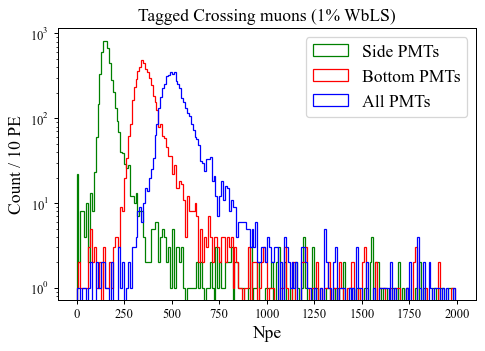

In [12]:
plot_range=[0, 2000]
nbinx=200

do_fit=False
plt.figure(dpi=90)
time_mask= (mu1['peak_time_crx']>=pT_min) & (mu1['peak_time_crx']<pT_max)
mask = time_mask
# side_mask = mu1['area_max_ch_id_crx']<=400
# mask = (time_mask) & (side_mask)

big_event_mask = mu1['area_sum_crx']>4000
#print(mu1['event_id_crx'][big_event_mask])

hist={}

# hist['side']=plt.hist(mu1['area_side_crx'], bins=nbinx, range=plot_range, 
#          color=color_list[2], histtype='step', label='Side PMTs')
# hist['bot']=plt.hist(mu1['area_bot_crx'], bins=nbinx, range=plot_range,  
#          color=color_list[1],  histtype='step', label='Bottom PMTs')
# hist['sum']=plt.hist(mu1['area_sum_crx'], bins=nbinx, range=plot_range,  
#          color=color_list[0],  histtype='step', label='All PMTs')
hist['side']=plt.hist(mu1['area_side_crx'][mask], bins=nbinx, range=plot_range, 
         color=color_list[2], histtype='step', label='Side PMTs')
hist['bot']=plt.hist(mu1['area_bot_crx'][mask], bins=nbinx, range=plot_range,  
         color=color_list[1],  histtype='step', label='Bottom PMTs')
hist['sum']=plt.hist(mu1['area_sum_crx'][mask], bins=nbinx, range=plot_range,  
         color=color_list[0],  histtype='step', label='All PMTs')

if do_fit:
    h=hist['side']
    fit_range=[120, 180]
    x = np.linspace(fit_range[0], fit_range[1], 100)
    mid = (fit_range[0]+fit_range[1])/2
    res = fit_gauss(h, fit_range=fit_range, p0=[mid, 10,100])
    y = gauss(x, res['popt'][0], res['popt'][1], res['popt'][2])
    print('side: ', 'rChi2=', res['chi2']/res['dof'], res['popt'], res['err'])
    plt.plot(x, y, color=color_list[2])
    
    h=hist['bot']
    fit_range=[310, 400]
    x = np.linspace(fit_range[0], fit_range[1], 100)
    mid = (fit_range[0]+fit_range[1])/2
    res = fit_gauss(h, fit_range=fit_range, p0=[mid, 10,100])
    y = gauss(x, res['popt'][0], res['popt'][1], res['popt'][2])
    print('Bot: ', 'rChi2=', res['chi2']/res['dof'], res['popt'], res['err'])
    plt.plot(x, y, color=color_list[1])
    
    h=hist['sum']
    fit_range=[440, 575]
    x = np.linspace(fit_range[0], fit_range[1], 100)
    mid = (fit_range[0]+fit_range[1])/2
    res = fit_gauss(h, fit_range=fit_range, p0=[mid, 10,100])
    y = gauss(x, res['popt'][0], res['popt'][1], res['popt'][2])
    print('Bot: ', 'rChi2=', res['chi2']/res['dof'], res['popt'], res['err'])
    plt.plot(x, y, color=color_list[0])

plt.legend(fontsize=14)
plt.title(r'Tagged Crossing muons (1% WbLS)', fontsize=14)
plt.xlabel('Npe', fontsize=14)
plt.yscale('log')
plt.ylabel('Count / %d PE' % ((plot_range[1]-plot_range[0])/nbinx),  fontsize=14)
# plt.xlim([0, 800])
# plt.ylim([1, 500])
plt.show()

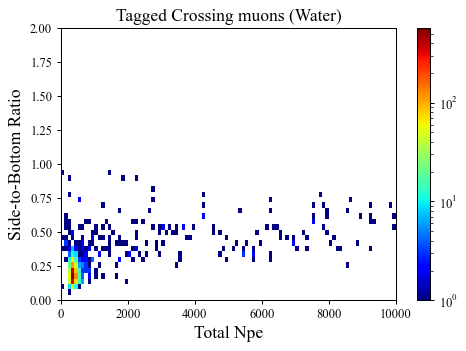

In [16]:
plt.figure(dpi=90)
pT_min = 370
pT_max = 405

h = plt.hist2d( mu0['area_sum_crx'],mu0['area_side_crx']/mu0['area_bot_crx'], bins=[100, 50], 
               range=((0, 10000),(0, 2)), norm=colors.LogNorm(), cmap='jet');
plt.colorbar()
plt.ylabel('Side-to-Bottom Ratio', fontsize=14)
plt.xlabel('Total Npe', fontsize=14)
plt.title(r'Tagged Crossing muons (Water)', fontsize=14)
plt.show()

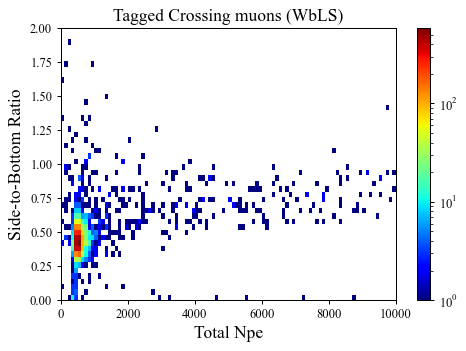

In [15]:
plt.figure(dpi=90)
pT_min = 370
pT_max = 405
h = plt.hist2d( mu1['area_sum_crx'], mu1['area_side_crx']/mu1['area_bot_crx'], bins=[100, 50], 
               range=((0, 10000),(0, 2)), norm=colors.LogNorm(), cmap='jet');
plt.colorbar()
plt.ylabel('Side-to-Bottom Ratio', fontsize=14)
plt.xlabel('Total Npe', fontsize=14)
plt.title(r'Tagged Crossing muons (WbLS)', fontsize=14)
plt.show()

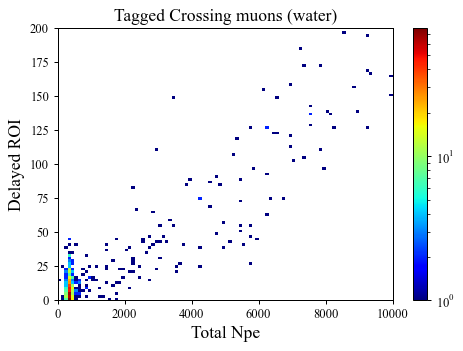

In [17]:
plt.figure(dpi=90)
pT_min = 370
pT_max = 405

roi2= mu0['area_side_roi2_crx']+ mu0['area_bot_roi2_crx']
h = plt.hist2d( mu0['area_sum_crx'], roi2, bins=[100, 100], 
               range=((0, 10000),(0, 200)), norm=colors.LogNorm(), cmap='jet');
plt.colorbar()
plt.ylabel('Delayed ROI', fontsize=14)
plt.xlabel('Total Npe', fontsize=14)
plt.title(r'Tagged Crossing muons (water)', fontsize=14)
plt.show()

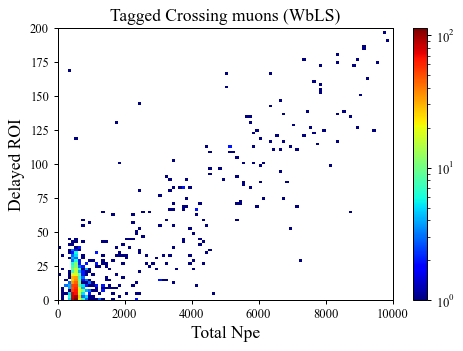

In [18]:
plt.figure(dpi=90)
pT_min = 370
pT_max = 405

roi2= mu1['area_side_roi2_crx']+ mu1['area_bot_roi2_crx']
h = plt.hist2d( mu1['area_sum_crx'], roi2, bins=[100, 100], 
               range=((0, 10000),(0, 200)), norm=colors.LogNorm(), cmap='jet');
plt.colorbar()
plt.ylabel('Delayed ROI', fontsize=14)
plt.xlabel('Total Npe', fontsize=14)
plt.title(r'Tagged Crossing muons (WbLS)', fontsize=14)
plt.show()

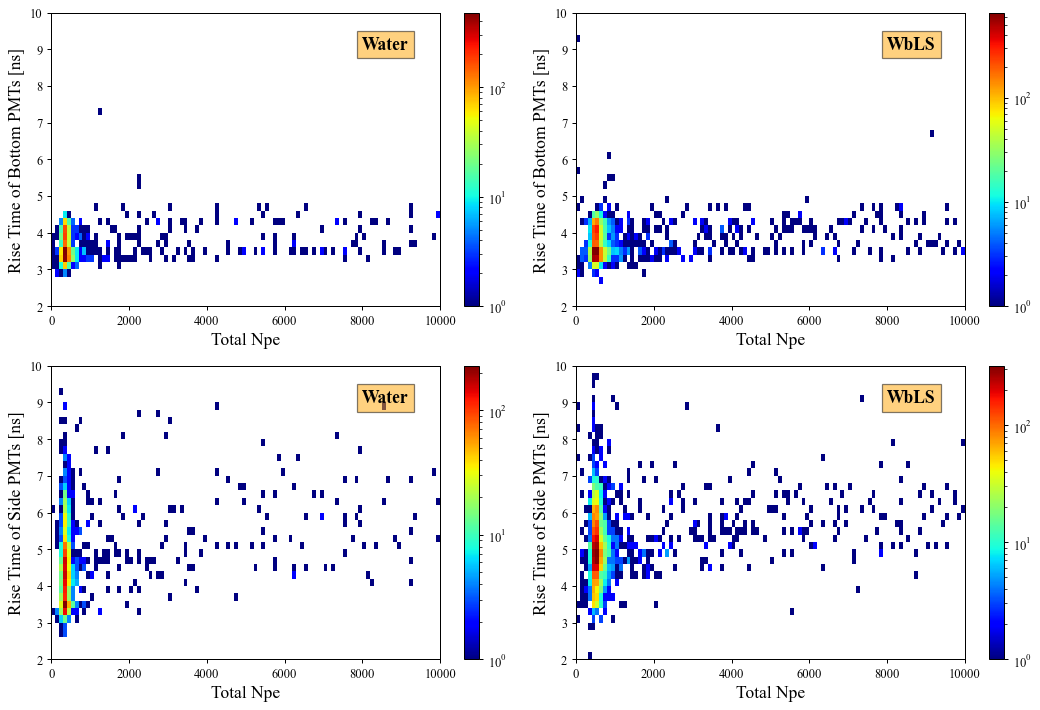

In [59]:
"""
Check peak time cut
"""

plt.figure(figsize=[12, 8], dpi=90)
plt.subplot(221)
h = plt.hist2d( mu0['area_sum_crx'],mu0['rise_bot_crx'], bins=[100, 40], 
               range=((0, 10000),(2, 10)), norm=colors.LogNorm(), cmap='jet');
plt.colorbar()
plt.ylabel('Rise Time of Bottom PMTs [ns]', fontsize=14)
plt.xlabel('Total Npe', fontsize=14)
plt.text(8000, 9, 'Water', fontsize=14, fontweight='bold', bbox=dict(facecolor='orange', alpha=0.5))

plt.subplot(222)
h = plt.hist2d( mu1['area_sum_crx'], mu1['rise_bot_crx'], bins=[100, 40], 
               range=((0, 10000),(2, 10)), norm=colors.LogNorm(), cmap='jet');
plt.colorbar()
plt.ylabel('Rise Time of Bottom PMTs [ns]', fontsize=14)
plt.xlabel('Total Npe', fontsize=14)
plt.text(8000, 9, 'WbLS', fontsize=14, fontweight='bold', bbox=dict(facecolor='orange', alpha=0.5))

plt.subplot(223)
h = plt.hist2d( mu0['area_sum_crx'],mu0['rise_side_crx'], bins=[100, 40], 
               range=((0, 10000),(2, 10)), norm=colors.LogNorm(), cmap='jet');
plt.colorbar()
plt.ylabel('Rise Time of Side PMTs [ns]', fontsize=14)
plt.xlabel('Total Npe', fontsize=14)
plt.text(8000, 9, 'Water', fontsize=14, fontweight='bold', bbox=dict(facecolor='orange', alpha=0.5))

plt.subplot(224)
h = plt.hist2d( mu1['area_sum_crx'], mu1['rise_side_crx'], bins=[100, 40], 
               range=((0, 10000),(2, 10)), norm=colors.LogNorm(), cmap='jet');
plt.colorbar()
plt.ylabel('Rise Time of Side PMTs [ns]', fontsize=14)
plt.xlabel('Total Npe', fontsize=14)
plt.text(8000, 9, 'WbLS', fontsize=14, fontweight='bold', bbox=dict(facecolor='orange', alpha=0.5))


plt.tight_layout()
plt.show()

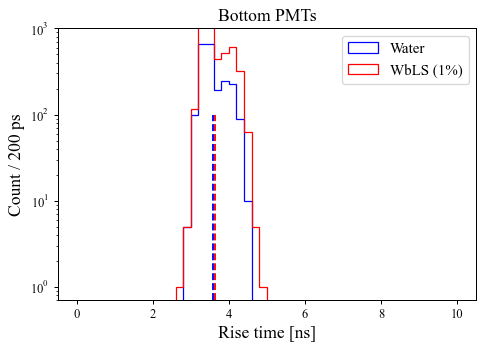

In [24]:
plt.figure(dpi=90)
plot_range=[0, 10]
nbinx=50

sbr0 = mu0['area_side_crx']/mu0['area_bot_crx']
sbr1 = mu1['area_side_crx']/mu1['area_bot_crx']

msk0= (mu0['area_sum_crx']>=200) & (mu0['area_sum_crx']<600) & (sbr0 > 0.05) & (sbr0 < 0.4)
msk1= (mu1['area_sum_crx']>=300) & (mu1['area_sum_crx']<900)  & (sbr1 > 0.25) & (sbr1 < 0.75)
plt.hist(mu0['rise_bot_crx'][msk0], bins=nbinx, range=plot_range, 
         color='blue', histtype='step', label='Water');
plt.hist(mu1['rise_bot_crx'][msk1], bins=nbinx, range=plot_range,  
         color='red',  histtype='step', label='WbLS (1%)');
plt.vlines(np.mean(mu0['rise_bot_crx'][msk0]), 0.7, 100, linestyles='--', color='blue')
plt.vlines(np.mean(mu1['rise_bot_crx'][msk1]), 0.7, 100, linestyles='--', color='red')
plt.legend()
plt.xlabel('Rise time [ns]')
plt.ylabel('Count / %d ps' % ((plot_range[1]-plot_range[0])/nbinx*1000))

plt.title("Bottom PMTs")
plt.yscale('log')
plt.ylim([0.7, 1000])
plt.show()

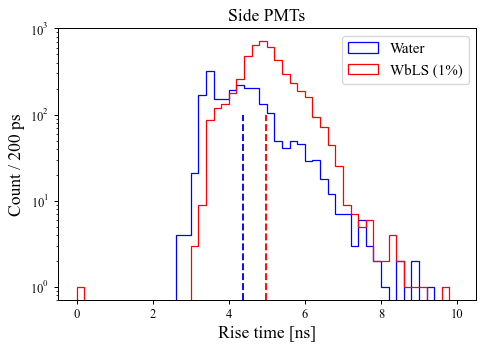

In [25]:
plt.figure(dpi=90)
plot_range=[0, 10]
nbinx=50
plt.hist(mu0['rise_side_crx'][msk0], bins=nbinx, range=plot_range, 
         color='blue', histtype='step', label='Water');
plt.hist(mu1['rise_side_crx'][msk1], bins=nbinx, range=plot_range,  
         color='red',  histtype='step', label='WbLS (1%)');
plt.vlines(np.mean(mu0['rise_side_crx'][msk0]), 0.7, 100, linestyles='--', color='blue')
plt.vlines(np.mean(mu1['rise_side_crx'][msk1]), 0.7, 100, linestyles='--', color='red')

plt.legend()
plt.xlabel('Rise time [ns]')
plt.ylabel('Count / %d ps' % ((plot_range[1]-plot_range[0])/nbinx*1000))
plt.title("Side PMTs")
plt.yscale('log')
plt.ylim([0.7, 1000])
plt.show()

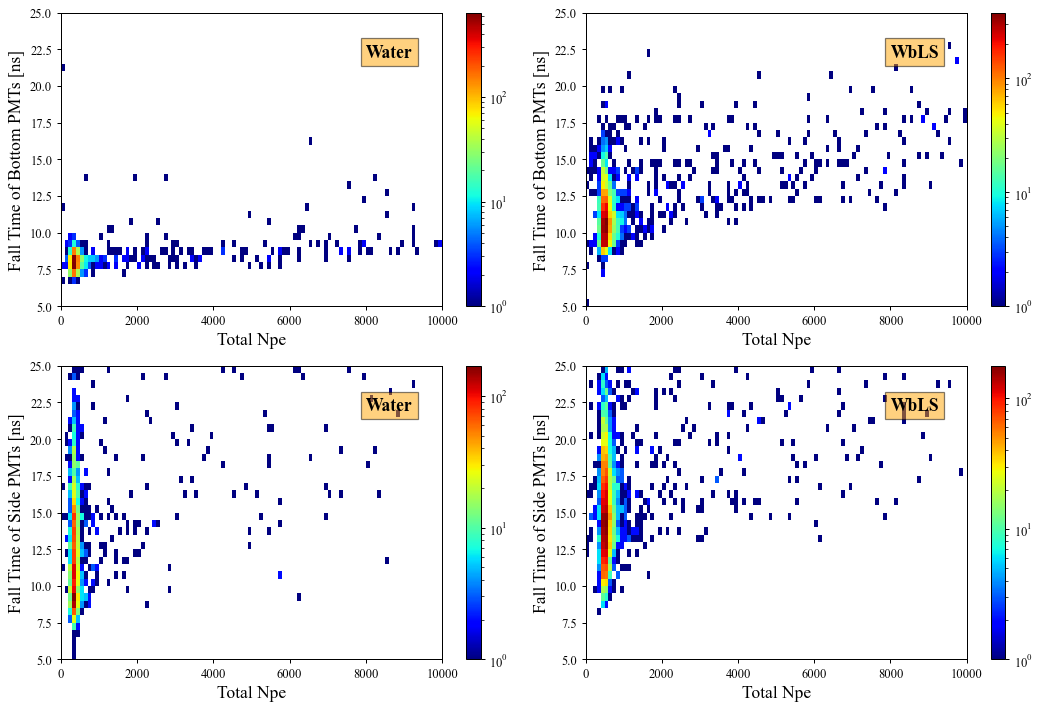

In [61]:
"""
Check peak time cut
"""

plt.figure(figsize=[12, 8], dpi=90)
plt.subplot(221)
h = plt.hist2d( mu0['area_sum_crx'],mu0['fall_bot_crx'], bins=[100, 40], 
               range=((0, 10000),(5, 25)), norm=colors.LogNorm(), cmap='jet');
plt.colorbar()
plt.ylabel('Fall Time of Bottom PMTs [ns]', fontsize=14)
plt.xlabel('Total Npe', fontsize=14)
plt.text(8000, 22, 'Water', fontsize=14, fontweight='bold', bbox=dict(facecolor='orange', alpha=0.5))

plt.subplot(222)
h = plt.hist2d( mu1['area_sum_crx'], mu1['fall_bot_crx'], bins=[100, 40], 
               range=((0, 10000),(5, 25)), norm=colors.LogNorm(), cmap='jet');
plt.colorbar()
plt.ylabel('Fall Time of Bottom PMTs [ns]', fontsize=14)
plt.xlabel('Total Npe', fontsize=14)
plt.text(8000, 22, 'WbLS', fontsize=14, fontweight='bold', bbox=dict(facecolor='orange', alpha=0.5))

plt.subplot(223)
h = plt.hist2d( mu0['area_sum_crx'], mu0['fall_side_crx'], bins=[100, 40], 
               range=((0, 10000),(5, 25)), norm=colors.LogNorm(), cmap='jet');
plt.colorbar()
plt.ylabel('Fall Time of Side PMTs [ns]', fontsize=14)
plt.xlabel('Total Npe', fontsize=14)
plt.text(8000, 22, 'Water', fontsize=14, fontweight='bold', bbox=dict(facecolor='orange', alpha=0.5))

plt.subplot(224)
h = plt.hist2d( mu1['area_sum_crx'], mu1['fall_side_crx'], bins=[100, 40], 
               range=((0, 10000),(5, 25)), norm=colors.LogNorm(), cmap='jet');
plt.colorbar()
plt.ylabel('Fall Time of Side PMTs [ns]', fontsize=14)
plt.xlabel('Total Npe', fontsize=14)
plt.text(8000, 22, 'WbLS', fontsize=14, fontweight='bold', bbox=dict(facecolor='orange', alpha=0.5))
plt.tight_layout()
plt.show()

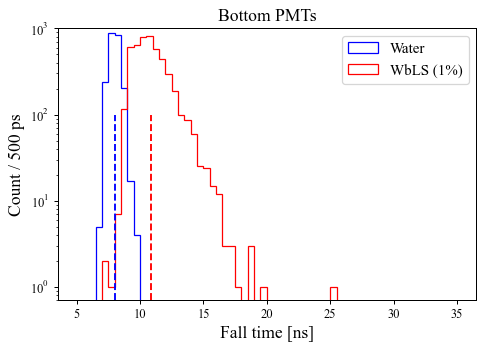

2188


In [100]:
plt.figure(dpi=90)
plot_range=[5, 35]
nbinx=60

sbr0 = mu0['area_side_crx']/mu0['area_bot_crx']
sbr1 = mu1['area_side_crx']/mu1['area_bot_crx']

msk0= (mu0['area_sum_crx']>=200) & (mu0['area_sum_crx']<600) & (sbr0 > 0.05) & (sbr0 < 0.4)
msk1= (mu1['area_sum_crx']>=300) & (mu1['area_sum_crx']<900)  & (sbr1 > 0.25) & (sbr1 < 0.75)
plt.hist(mu0['fall_bot_crx'][msk0], bins=nbinx, range=plot_range, 
         color='blue', histtype='step', label='Water');
plt.hist(mu1['fall_bot_crx'][msk1], bins=nbinx, range=plot_range,  
         color='red',  histtype='step', label='WbLS (1%)');
plt.vlines(np.mean(mu0['fall_bot_crx'][msk0]), 0.7, 100, linestyles='--', color='blue')
plt.vlines(np.mean(mu1['fall_bot_crx'][msk1]), 0.7, 100, linestyles='--', color='red')
plt.legend()
plt.xlabel('Fall time [ns]')
plt.ylabel('Count / %d ps' % ((plot_range[1]-plot_range[0])/nbinx*1000))

plt.title("Bottom PMTs")
plt.yscale('log')
plt.ylim([0.7, 1000])
plt.show()
print(len(mu0['fall_bot_crx'][msk0]))

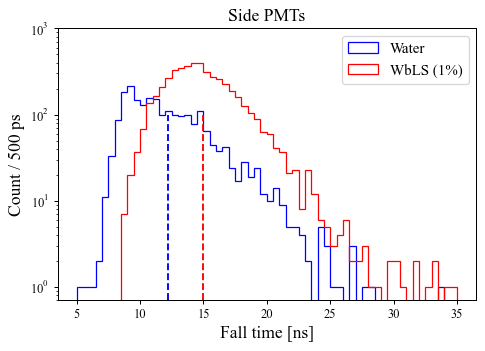

In [39]:
plt.figure(dpi=90)
plot_range=[5, 35]
nbinx=60
plt.hist(mu0['fall_side_crx'][msk0], bins=nbinx, range=plot_range, 
         color='blue', histtype='step', label='Water');
plt.hist(mu1['fall_side_crx'][msk1], bins=nbinx, range=plot_range,  
         color='red',  histtype='step', label='WbLS (1%)');
plt.vlines(np.mean(mu0['fall_side_crx'][msk0]), 0.7, 100, linestyles='--', color='blue')
plt.vlines(np.mean(mu1['fall_side_crx'][msk1]), 0.7, 100, linestyles='--', color='red')

plt.legend()
plt.xlabel('Fall time [ns]')
plt.ylabel('Count / %d ps' % ((plot_range[1]-plot_range[0])/nbinx*1000))
plt.title("Side PMTs")
plt.yscale('log')
plt.ylim([0.7, 1000])
plt.show()

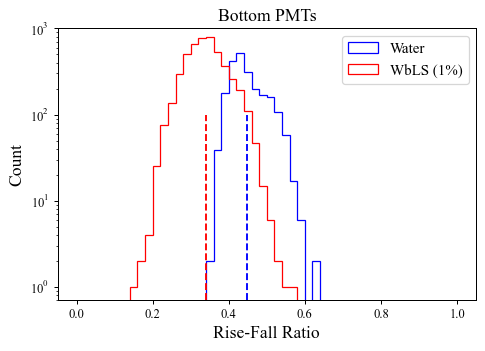

In [66]:
plt.figure(dpi=90)
plot_range=[0, 1]
nbinx=50

sbr0 = mu0['area_side_crx']/mu0['area_bot_crx']
sbr1 = mu1['area_side_crx']/mu1['area_bot_crx']
msk0= (mu0['area_sum_crx']>=200) & (mu0['area_sum_crx']<600) & (sbr0 > 0.05) & (sbr0 < 0.4)
msk1= (mu1['area_sum_crx']>=300) & (mu1['area_sum_crx']<900)  & (sbr1 > 0.25) & (sbr1 < 0.75)

rfr0 = mu0['rise_bot_crx'][msk0]/mu0['fall_bot_crx'][msk0]
rfr1 = mu1['rise_bot_crx'][msk1]/mu1['fall_bot_crx'][msk1]
plt.hist(rfr0, bins=nbinx, range=plot_range, 
         color='blue', histtype='step', label='Water');
plt.hist(rfr1, bins=nbinx, range=plot_range,  
         color='red',  histtype='step', label='WbLS (1%)');
plt.vlines(np.mean(rfr0), 0.7, 100, linestyles='--', color='blue')
plt.vlines(np.mean(rfr1), 0.7, 100, linestyles='--', color='red')
plt.legend()
plt.xlabel('Rise-Fall Ratio')
plt.ylabel('Count')
plt.title("Bottom PMTs")
plt.yscale('log')
plt.ylim([0.7, 1000])
plt.show()

/var/folders/j2/xx2nfy1d7kl54yfk4m9z36080000gn/T/ipykernel_9174/2880737927.py:10: RuntimeWarning: invalid value encountered in true_divide
  rfr1 = mu1['rise_side_crx'][msk1]/mu1['fall_side_crx'][msk1]


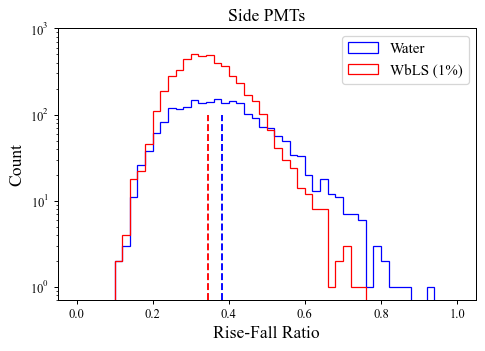

In [99]:
plt.figure(dpi=90)
plot_range=[0, 1]
nbinx=50

sbr0 = mu0['area_side_crx']/mu0['area_bot_crx']
sbr1 = mu1['area_side_crx']/mu1['area_bot_crx']
msk0= (mu0['area_sum_crx']>=200) & (mu0['area_sum_crx']<600) & (sbr0 > 0.05) & (sbr0 < 0.4)
msk1= (mu1['area_sum_crx']>=300) & (mu1['area_sum_crx']<900)  & (sbr1 > 0.25) & (sbr1 < 0.75)
rfr0 = mu0['rise_side_crx'][msk0]/mu0['fall_side_crx'][msk0]
rfr1 = mu1['rise_side_crx'][msk1]/mu1['fall_side_crx'][msk1]
rfr0 = rfr0[np.logical_not(np.isnan(rfr0))]
rfr1 = rfr1[np.logical_not(np.isnan(rfr1))]
plt.hist(rfr0, bins=nbinx, range=plot_range, 
         color='blue', histtype='step', label='Water');
plt.hist(rfr1, bins=nbinx, range=plot_range,  
         color='red',  histtype='step', label='WbLS (1%)');
plt.vlines(np.mean(rfr0), 0.7, 100, linestyles='--', color='blue')
plt.vlines(np.mean(rfr1), 0.7, 100, linestyles='--', color='red')
plt.legend()
plt.xlabel('Rise-Fall Ratio')
plt.ylabel('Count')
plt.title("Side PMTs")
plt.yscale('log')
plt.ylim([0.7, 1000])
plt.show()

In [98]:

rfr1[3200:3250][np.logical_not(np.isnan(rfr1[3200:3250]))]

array([ 0.23002464,  0.14731233, -1.4727782 ,  0.34010988,  0.37273753,
        0.25376278,  0.23813617,  0.16297986,  0.20546529,  0.25634846,
        0.1316477 ,  0.13599414,  0.11682697,  0.17088296,  0.4821194 ,
        0.40724677,  0.35976925,  0.21409166,  0.24559426,  0.31454957,
        0.33259737,  0.13649333,  0.5538185 ,  0.21617879,  0.15954395,
        0.28754523,  0.26366428,  0.18165916,  0.32898188,  0.4779357 ,
        0.32419875,  0.41174904,  0.6288152 ,  0.4016781 ,  0.26521862,
        0.31961438,  0.2684206 ,  0.3189586 ,  0.3268833 ,  0.41757843,
        0.29265952,  0.41794553,  0.22411387,  0.32046402,  0.32030916,
        0.26500908,  0.38574204,  0.40368482,  0.3240594 ], dtype=float32)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


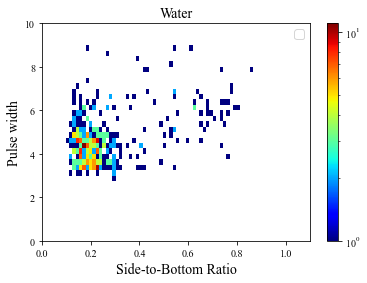

In [19]:
"""
Check peak time cut
"""

plt.figure()
pT_min = 370
pT_max = 405
h = plt.hist2d(mu0['area_side_crx']/mu0['area_bot_crx'], mu0['rise_side_crx'], bins=[80, 40], range=((0, 1.1), (0, 10)), norm=colors.LogNorm(), cmap='jet');
plt.colorbar()
plt.xlabel('Side-to-Bottom Ratio', fontsize=14)
plt.ylabel('Pulse width', fontsize=14)
plt.title('Water')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


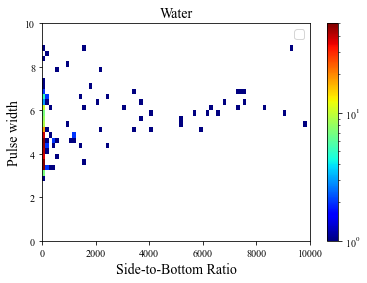

In [22]:
"""
Check peak time cut
"""

plt.figure()
pT_min = 370
pT_max = 405
h = plt.hist2d(mu0['area_side_crx'], mu0['rise_side_crx'], bins=[80, 40], range=((0, 10000), (0, 10)), norm=colors.LogNorm(), cmap='jet');
plt.colorbar()
plt.xlabel('Side-to-Bottom Ratio', fontsize=14)
plt.ylabel('Pulse width', fontsize=14)
plt.title('Water')
plt.legend()
plt.show()

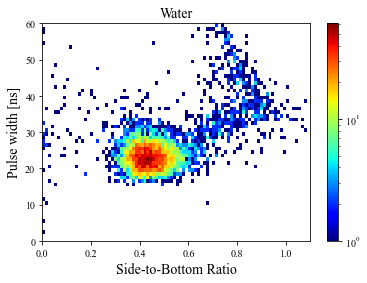

In [142]:
"""
Check peak time cut
"""

plt.figure()
pT_min = 370
pT_max = 405
h = plt.hist2d(mu1['area_side_crx']/mu1['area_bot_crx'], mu1['rise_side_crx'], bins=[90, 60], range=((0, 1.1), (0, 60)), norm=colors.LogNorm(), cmap='jet');
plt.colorbar()
plt.xlabel('Side-to-Bottom Ratio', fontsize=14)
plt.ylabel('Pulse width [ns]', fontsize=14)
plt.title('Water')
plt.show()

In [ ]:
bot_mask = mu0['area_max_ch_id_crx']<300
plt.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


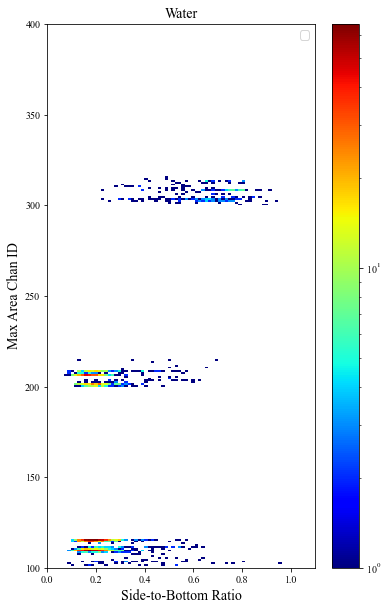

In [143]:
"""
Check peak time cut
"""

plt.figure(figsize=[, 10])
pT_min = 370
pT_max = 405
h = plt.hist2d(mu0['area_side_crx']/mu0['area_bot_crx'], mu0['area_max_ch_id_crx'], bins=[80, 300], range=((0, 1.1), (100, 400)), norm=colors.LogNorm(), cmap='jet');
plt.colorbar()
plt.xlabel('Side-to-Bottom Ratio', fontsize=14)
plt.ylabel('Max Area Chan ID', fontsize=14)
plt.title('Water')
plt.legend()
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


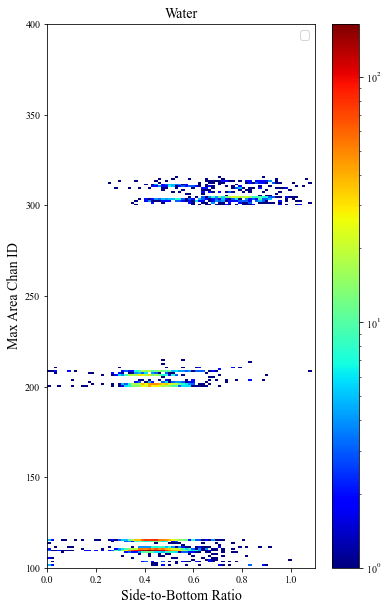

In [144]:
"""
Check peak time cut
"""

plt.figure(figsize=[6, 10])
pT_min = 370
pT_max = 405
h = plt.hist2d(mu1['area_side_crx']/mu1['area_bot_crx'], mu1['area_max_ch_id_crx'], bins=[80, 300], range=((0, 1.1), (100, 400)), norm=colors.LogNorm(), cmap='jet');
plt.colorbar()
plt.xlabel('Side-to-Bottom Ratio', fontsize=14)
plt.ylabel('Max Area Chan ID', fontsize=14)
plt.title('Water')
plt.legend()
plt.show()

In [ ]:
mu0['area_max_ch_id_crx']